In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd
from torchaudio.datasets import SPEECHCOMMANDS
import os
from tqdm import tqdm

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))    # 这里就一个数


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    # 用0填充，使一个batch有相同的长度
    batch = [item.t() for item in batch]  # 转置
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]   # 每个波形（tensor类型）加入到列表tensor中
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)   # 得到tensor的batch
    targets = torch.stack(targets)  # 连接，在新的维度进行堆叠   得到targets

    return tensors, targets


In [15]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, path, subset: str = None):
        super().__init__(path, download=False)
# FileNotFoundError: [Errno 2] No such file or directory: './123\\SpeechCommands\\speech_commands_v0.02\\validation_list.txt'
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
#             print(self._path)   # 下划线不会影响使用，通常作为类内提示：用于类内名称
#             print(filepath)
            with open(filepath) as fileobj:   # strip 去掉空格
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]
            # nrompath:规范化路径
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
            print(self._walker)
            print('validation dataset is loaded')
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
#             print(self._walker)

        if subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)  # 设置为集合
            self._walker = [w for w in self._walker if w not in excludes]  # 这里排除test和val中的文件。但这里self._walker怎么来的？


            
def create_dataloader(path, batch_size = 256, train = True, shuffle = True, drop_last=False, collate_fn=None):
    # Create training and testing split of the data. We do not use validation in this tutorial.
    if train:
        dataset = SubsetSC(path, "training")
    else:
        dataset = SubsetSC(path, "testing")

    if device == "cuda":
        num_workers = 1
        pin_memory = True
    else:
        num_workers = 0
        pin_memory = False

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn,
        drop_last = drop_last,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
#     test_loader = torch.utils.data.DataLoader(
#         test_set,
#         batch_size=batch_size,
#         shuffle=False,
#         drop_last=False,
#         collate_fn=collate_fn,
#         num_workers=num_workers,
#         pin_memory=pin_memory,
#     )

    return dataloader
batch_size = 256

train_loader = create_dataloader(path = './', batch_size = batch_size, train = True, shuffle = True,drop_last = True, collate_fn=collate_fn)


test_loader = create_dataloader(path = './', batch_size = batch_size, train = True, shuffle = False,drop_last = False, collate_fn=collate_fn)

In [21]:
train_set = SubsetSC('./', "training")  # 用于函数参数传递
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))  # 所有的类
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [23]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):   # 这里迭代返回的是data和target

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [24]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):   # 匹配最接近的类别
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]E:\Anaconda_new\envs\pytorch\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                            | 0.0030165912518853697/5 [00:04<1:52:51, 1355.21s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.749233


  1%|▍                                                                | 0.03318250377073908/5 [00:08<09:28, 114.52s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.150290


  1%|▊                                                                 | 0.0633484162895928/5 [00:11<09:44, 118.34s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.687431


  2%|█▏                                                               | 0.09351432880844639/5 [00:15<08:40, 106.00s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.395889


  2%|█▌                                                               | 0.12368024132729998/5 [00:18<08:47, 108.11s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.152507


  3%|█▉                                                               | 0.15384615384615358/5 [00:21<08:25, 104.28s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.068889


  4%|██▍                                                              | 0.18401206636500717/5 [00:24<08:53, 110.85s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.669636


  4%|██▊                                                              | 0.21417797888386075/5 [00:28<08:39, 108.60s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.816581


  5%|███▏                                                             | 0.24434389140271434/5 [00:31<08:23, 105.87s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.686755


  5%|███▌                                                             | 0.27450980392156793/5 [00:34<07:52, 100.09s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.499830


  6%|████                                                              | 0.3046757164404215/5 [00:38<09:35, 122.53s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.634121


  7%|████▍                                                             | 0.3348416289592751/5 [00:41<08:53, 114.39s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.185413


  7%|████▊                                                             | 0.3650075414781287/5 [00:45<08:56, 115.71s/it]

Train Epoch: 1 [61440/84843 (73%)]	Loss: 1.392448


  8%|█████▏                                                            | 0.3951734539969823/5 [00:48<08:21, 108.96s/it]

Train Epoch: 1 [66560/84843 (79%)]	Loss: 1.243399


  9%|█████▌                                                           | 0.42533936651583587/5 [00:52<07:54, 103.62s/it]

Train Epoch: 1 [71680/84843 (85%)]	Loss: 1.209621


  9%|█████▉                                                           | 0.45550527903468946/5 [00:55<08:02, 106.24s/it]

Train Epoch: 1 [76800/84843 (91%)]	Loss: 1.201019


 10%|██████▎                                                          | 0.48567119155354305/5 [00:58<08:11, 108.97s/it]

Train Epoch: 1 [81920/84843 (97%)]	Loss: 1.198311


 20%|█████████████▏                                                    | 0.9984917043740541/5 [01:56<07:30, 112.56s/it]


Test Epoch: 1	Accuracy: 53556/84843 (63%)



 20%|█████████████▏                                                    | 1.0030165912518823/5 [01:57<06:59, 105.08s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.087778


 21%|█████████████▋                                                    | 1.0331825037707358/5 [02:00<07:46, 117.56s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.209911


 21%|██████████████                                                    | 1.0633484162895894/5 [02:04<07:16, 110.93s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.297961


 22%|██████████████▋                                                    | 1.093514328808443/5 [02:07<07:58, 122.44s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.137412


 22%|██████████████▊                                                   | 1.1236802413272966/5 [02:11<07:26, 115.28s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.034051


 23%|███████████████▏                                                  | 1.1538461538461502/5 [02:15<07:09, 111.63s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.222204


 24%|███████████████▋                                                  | 1.1840120663650038/5 [02:18<07:15, 114.01s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 1.044698


 24%|████████████████                                                  | 1.2141779788838574/5 [02:22<06:41, 105.96s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.894668


 25%|████████████████▋                                                  | 1.244343891402711/5 [02:25<07:08, 114.20s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.839506


 25%|████████████████▊                                                 | 1.2745098039215645/5 [02:29<07:15, 116.88s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.917167


 26%|█████████████████▏                                                | 1.3046757164404181/5 [02:32<06:35, 107.14s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.800538


 27%|█████████████████▌                                                | 1.3348416289592717/5 [02:36<07:24, 121.41s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.754221


 27%|██████████████████                                                | 1.3650075414781253/5 [02:39<06:41, 110.37s/it]

Train Epoch: 2 [61440/84843 (73%)]	Loss: 1.005571


 28%|██████████████████▋                                                | 1.395173453996979/5 [02:42<06:59, 116.46s/it]

Train Epoch: 2 [66560/84843 (79%)]	Loss: 0.930617


 29%|██████████████████▊                                               | 1.4253393665158325/5 [02:46<06:32, 109.79s/it]

Train Epoch: 2 [71680/84843 (85%)]	Loss: 0.954498


 29%|███████████████████▌                                               | 1.455505279034686/5 [02:49<07:13, 122.40s/it]

Train Epoch: 2 [76800/84843 (91%)]	Loss: 0.886747


 30%|███████████████████▌                                              | 1.4856711915535397/5 [02:53<06:12, 105.99s/it]

Train Epoch: 2 [81920/84843 (97%)]	Loss: 0.972659


 40%|██████████████████████████▍                                       | 1.9984917043740507/5 [03:52<07:10, 143.34s/it]


Test Epoch: 2	Accuracy: 60967/84843 (72%)



 40%|██████████████████████████▍                                       | 2.0030165912518787/5 [03:53<06:12, 124.18s/it]

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.995723


 41%|██████████████████████████▊                                       | 2.0331825037707323/5 [03:57<06:32, 132.13s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.658087


 41%|███████████████████████████▋                                       | 2.063348416289586/5 [04:00<05:51, 119.55s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.908982


 42%|███████████████████████████▋                                      | 2.0935143288084395/5 [04:04<05:10, 106.98s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.771174


 42%|████████████████████████████▍                                      | 2.123680241327293/5 [04:07<05:29, 114.72s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.770436


 43%|████████████████████████████▊                                      | 2.152337858220204/5 [04:12<07:14, 152.68s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.962322


 44%|████████████████████████████▊                                     | 2.1840120663650002/5 [04:16<05:39, 120.64s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.844374


 44%|█████████████████████████████▋                                     | 2.214177978883854/5 [04:19<05:08, 110.61s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.852425


 45%|█████████████████████████████▋                                    | 2.2443438914027074/5 [04:23<04:42, 102.44s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.906613


 45%|██████████████████████████████▍                                    | 2.274509803921561/5 [04:26<06:07, 134.81s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.726481


 46%|██████████████████████████████▍                                   | 2.3046757164404146/5 [04:30<05:02, 112.19s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.855322


 47%|███████████████████████████████▎                                   | 2.334841628959268/5 [04:34<04:52, 109.82s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.821854


 47%|███████████████████████████████▏                                  | 2.3650075414781218/5 [04:37<04:50, 110.42s/it]

Train Epoch: 3 [61440/84843 (73%)]	Loss: 0.788838


 48%|███████████████████████████████▌                                  | 2.3951734539969753/5 [04:40<04:47, 110.35s/it]

Train Epoch: 3 [66560/84843 (79%)]	Loss: 0.782621


 49%|████████████████████████████████▍                                  | 2.425339366515829/5 [04:44<04:35, 106.82s/it]

Train Epoch: 3 [71680/84843 (85%)]	Loss: 0.687275


 49%|████████████████████████████████▍                                 | 2.4555052790346825/5 [04:47<04:52, 115.08s/it]

Train Epoch: 3 [76800/84843 (91%)]	Loss: 0.748862


 50%|█████████████████████████████████▎                                 | 2.485671191553536/5 [04:51<05:15, 125.65s/it]

Train Epoch: 3 [81920/84843 (97%)]	Loss: 0.726304


 60%|████████████████████████████████████████▏                          | 2.998491704374047/5 [05:49<03:46, 113.30s/it]


Test Epoch: 3	Accuracy: 64994/84843 (77%)



 60%|████████████████████████████████████████▏                          | 3.003016591251875/5 [05:50<03:31, 106.13s/it]

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.786013


 61%|████████████████████████████████████████                          | 3.0331825037707287/5 [05:53<03:44, 114.22s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.758093


 61%|████████████████████████████████████████▍                         | 3.0633484162895823/5 [05:57<03:26, 106.59s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.818975


 62%|█████████████████████████████████████████▍                         | 3.093514328808436/5 [06:00<03:37, 113.85s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.613099


 62%|█████████████████████████████████████████▏                        | 3.1236802413272895/5 [06:04<03:36, 115.15s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.628858


 63%|██████████████████████████████████████████▎                        | 3.153846153846143/5 [06:07<03:26, 111.64s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.680686


 64%|██████████████████████████████████████████                        | 3.1840120663649967/5 [06:10<03:08, 103.72s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.798226


 64%|██████████████████████████████████████████▍                       | 3.2141779788838503/5 [06:14<03:11, 107.37s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.607236


 65%|███████████████████████████████████████████▍                       | 3.244343891402704/5 [06:17<03:06, 106.02s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.560555


 65%|███████████████████████████████████████████▏                      | 3.2745098039215574/5 [06:21<03:10, 110.49s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.643860


 66%|████████████████████████████████████████████▎                      | 3.304675716440411/5 [06:24<03:04, 108.89s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.915513


 67%|████████████████████████████████████████████                      | 3.3348416289592646/5 [06:28<03:15, 117.55s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.754681


 67%|█████████████████████████████████████████████                      | 3.365007541478118/5 [06:31<03:04, 112.92s/it]

Train Epoch: 4 [61440/84843 (73%)]	Loss: 0.755014


 68%|█████████████████████████████████████████████▍                     | 3.395173453996972/5 [06:34<02:54, 108.68s/it]

Train Epoch: 4 [66560/84843 (79%)]	Loss: 0.812343


 69%|█████████████████████████████████████████████▏                    | 3.4253393665158254/5 [06:38<02:43, 104.13s/it]

Train Epoch: 4 [71680/84843 (85%)]	Loss: 0.668527


 69%|██████████████████████████████████████████████▎                    | 3.455505279034679/5 [06:41<02:55, 113.45s/it]

Train Epoch: 4 [76800/84843 (91%)]	Loss: 0.745437


 70%|██████████████████████████████████████████████                    | 3.4856711915535326/5 [06:44<02:45, 109.26s/it]

Train Epoch: 4 [81920/84843 (97%)]	Loss: 0.641290


 80%|████████████████████████████████████████████████████▊             | 3.9984917043740436/5 [07:43<01:50, 110.65s/it]


Test Epoch: 4	Accuracy: 63454/84843 (75%)



 80%|█████████████████████████████████████████████████████▋             | 4.003016591251872/5 [07:43<01:40, 101.25s/it]

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.688333


 81%|██████████████████████████████████████████████████████             | 4.033182503770726/5 [07:47<01:55, 119.49s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.580052


 81%|██████████████████████████████████████████████████████▍            | 4.063348416289579/5 [07:50<01:38, 104.89s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.691018


 82%|██████████████████████████████████████████████████████▊            | 4.093514328808433/5 [07:54<01:38, 108.15s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.584532


 82%|███████████████████████████████████████████████████████▎           | 4.123680241327286/5 [07:57<01:35, 109.08s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.780570


 83%|████████████████████████████████████████████████████████▍           | 4.15384615384614/5 [08:00<01:31, 108.25s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.627181


 84%|████████████████████████████████████████████████████████           | 4.184012066364994/5 [08:04<01:24, 103.72s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.781085


 84%|████████████████████████████████████████████████████████▍          | 4.214177978883847/5 [08:07<01:23, 106.55s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.558789


 85%|████████████████████████████████████████████████████████▊          | 4.244343891402701/5 [08:10<01:24, 111.59s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.858495


 85%|█████████████████████████████████████████████████████████▎         | 4.274509803921554/5 [08:14<01:19, 109.04s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.649661


 86%|█████████████████████████████████████████████████████████▋         | 4.304675716440408/5 [08:17<01:15, 107.93s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.551763


 87%|█████████████████████████████████████████████████████████▏        | 4.3348416289592615/5 [08:20<01:16, 115.10s/it]

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.814469


 87%|██████████████████████████████████████████████████████████▍        | 4.365007541478115/5 [08:24<01:08, 107.92s/it]

Train Epoch: 5 [61440/84843 (73%)]	Loss: 0.683251


 88%|██████████████████████████████████████████████████████████▉        | 4.395173453996969/5 [08:27<01:04, 105.84s/it]

Train Epoch: 5 [66560/84843 (79%)]	Loss: 0.551029


 89%|███████████████████████████████████████████████████████████▎       | 4.425339366515822/5 [08:30<01:06, 115.14s/it]

Train Epoch: 5 [71680/84843 (85%)]	Loss: 0.673506


 89%|███████████████████████████████████████████████████████████▋       | 4.455505279034676/5 [08:34<00:56, 104.67s/it]

Train Epoch: 5 [76800/84843 (91%)]	Loss: 0.636364


 90%|███████████████████████████████████████████████████████████▏      | 4.4856711915535294/5 [08:37<00:54, 105.16s/it]

Train Epoch: 5 [81920/84843 (97%)]	Loss: 0.666312


100%|██████████████████████████████████████████████████████████████████▉| 4.999999999999983/5 [09:35<00:00, 115.17s/it]



Test Epoch: 5	Accuracy: 68271/84843 (80%)



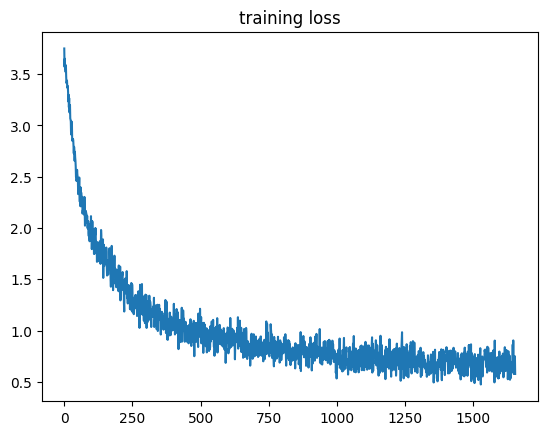

In [25]:
log_interval = 20
n_epoch = 5

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

In [26]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)  # 使用一个音频信号的tensor进行检测
#     print('before',tensor.shape)
    tensor = transform(tensor)  # transform定义中，固定了ori_fre = 16000 不具有普适性，因此输入的tensor要求频率为16000
#     print('after transform', tensor.shape)
#     print('tensor.unsqueeze(0)', tensor.unsqueeze(0).shape)
    
    ##########  问题解决   #####################
    tensor = model(tensor.unsqueeze(0))  # 将tensor在0的位置加一个维度，模拟batch_size的值
#     print('model处理后的',tensor.shape)
#     print('model处理后的',tensor)
    tensor = get_likely_index(tensor)   # 得到最可能的一个tensor
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]     # 使用train_set的进行预测，这里是为什么？应该使用test的的吧
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


In [29]:
wrong = 0
right = 0
test_set = SubsetSC('./', "testing")
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    if waveform.shape[1] != 16000:
        continue
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"#####Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        wrong += 1
        
    else:
#         print("All examples in this dataset were correctly classified!")
#         print("In this case, let's just look at the last data point")
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        right += 1
        print(f"!!!!!Data point #{i}. Expected: {utterance}. Predicted: {output}.")

!!!!!Data point #0. Expected: right. Predicted: right.
#####Data point #1. Expected: right. Predicted: nine.
!!!!!Data point #2. Expected: right. Predicted: right.
!!!!!Data point #4. Expected: right. Predicted: right.
!!!!!Data point #5. Expected: right. Predicted: right.
!!!!!Data point #6. Expected: right. Predicted: right.
!!!!!Data point #7. Expected: right. Predicted: right.
!!!!!Data point #8. Expected: right. Predicted: right.
#####Data point #9. Expected: right. Predicted: zero.
#####Data point #10. Expected: right. Predicted: eight.
#####Data point #11. Expected: right. Predicted: backward.
!!!!!Data point #12. Expected: right. Predicted: right.
!!!!!Data point #13. Expected: right. Predicted: right.
!!!!!Data point #14. Expected: right. Predicted: right.
#####Data point #15. Expected: right. Predicted: bed.
#####Data point #16. Expected: right. Predicted: left.
#####Data point #17. Expected: right. Predicted: wow.
!!!!!Data point #18. Expected: right. Predicted: right.
#####

!!!!!Data point #166. Expected: right. Predicted: right.
!!!!!Data point #167. Expected: right. Predicted: right.
#####Data point #168. Expected: right. Predicted: four.
!!!!!Data point #169. Expected: right. Predicted: right.
!!!!!Data point #170. Expected: right. Predicted: right.
#####Data point #171. Expected: right. Predicted: bird.
!!!!!Data point #172. Expected: right. Predicted: right.
#####Data point #173. Expected: right. Predicted: left.
!!!!!Data point #174. Expected: right. Predicted: right.
!!!!!Data point #175. Expected: right. Predicted: right.
!!!!!Data point #176. Expected: right. Predicted: right.
#####Data point #177. Expected: right. Predicted: up.
!!!!!Data point #178. Expected: right. Predicted: right.
!!!!!Data point #179. Expected: right. Predicted: right.
!!!!!Data point #180. Expected: right. Predicted: right.
!!!!!Data point #182. Expected: right. Predicted: right.
!!!!!Data point #184. Expected: right. Predicted: right.
!!!!!Data point #185. Expected: right

!!!!!Data point #382. Expected: right. Predicted: right.
!!!!!Data point #383. Expected: right. Predicted: right.
!!!!!Data point #384. Expected: right. Predicted: right.
!!!!!Data point #385. Expected: right. Predicted: right.
!!!!!Data point #386. Expected: right. Predicted: right.
!!!!!Data point #387. Expected: right. Predicted: right.
!!!!!Data point #388. Expected: right. Predicted: right.
!!!!!Data point #389. Expected: right. Predicted: right.
!!!!!Data point #390. Expected: right. Predicted: right.
!!!!!Data point #391. Expected: right. Predicted: right.
!!!!!Data point #392. Expected: right. Predicted: right.
#####Data point #393. Expected: right. Predicted: six.
#####Data point #395. Expected: right. Predicted: learn.
!!!!!Data point #396. Expected: eight. Predicted: eight.
#####Data point #397. Expected: eight. Predicted: tree.
!!!!!Data point #398. Expected: eight. Predicted: eight.
!!!!!Data point #399. Expected: eight. Predicted: eight.
!!!!!Data point #400. Expected: ei

!!!!!Data point #613. Expected: eight. Predicted: eight.
!!!!!Data point #614. Expected: eight. Predicted: eight.
!!!!!Data point #615. Expected: eight. Predicted: eight.
!!!!!Data point #616. Expected: eight. Predicted: eight.
!!!!!Data point #617. Expected: eight. Predicted: eight.
!!!!!Data point #618. Expected: eight. Predicted: eight.
!!!!!Data point #620. Expected: eight. Predicted: eight.
!!!!!Data point #621. Expected: eight. Predicted: eight.
#####Data point #622. Expected: eight. Predicted: three.
#####Data point #623. Expected: eight. Predicted: three.
!!!!!Data point #624. Expected: eight. Predicted: eight.
#####Data point #625. Expected: eight. Predicted: three.
!!!!!Data point #626. Expected: eight. Predicted: eight.
!!!!!Data point #627. Expected: eight. Predicted: eight.
!!!!!Data point #628. Expected: eight. Predicted: eight.
!!!!!Data point #629. Expected: eight. Predicted: eight.
!!!!!Data point #630. Expected: eight. Predicted: eight.
!!!!!Data point #631. Expected:

!!!!!Data point #784. Expected: eight. Predicted: eight.
!!!!!Data point #785. Expected: eight. Predicted: eight.
!!!!!Data point #786. Expected: eight. Predicted: eight.
!!!!!Data point #787. Expected: eight. Predicted: eight.
!!!!!Data point #789. Expected: eight. Predicted: eight.
!!!!!Data point #790. Expected: eight. Predicted: eight.
!!!!!Data point #791. Expected: eight. Predicted: eight.
!!!!!Data point #792. Expected: eight. Predicted: eight.
!!!!!Data point #793. Expected: eight. Predicted: eight.
!!!!!Data point #794. Expected: eight. Predicted: eight.
!!!!!Data point #795. Expected: eight. Predicted: eight.
!!!!!Data point #797. Expected: eight. Predicted: eight.
!!!!!Data point #798. Expected: eight. Predicted: eight.
!!!!!Data point #799. Expected: eight. Predicted: eight.
!!!!!Data point #801. Expected: eight. Predicted: eight.
#####Data point #802. Expected: eight. Predicted: off.
#####Data point #803. Expected: eight. Predicted: tree.
!!!!!Data point #804. Expected: ca

!!!!!Data point #1022. Expected: tree. Predicted: tree.
#####Data point #1023. Expected: tree. Predicted: two.
#####Data point #1024. Expected: tree. Predicted: three.
#####Data point #1025. Expected: tree. Predicted: three.
!!!!!Data point #1026. Expected: tree. Predicted: tree.
!!!!!Data point #1027. Expected: tree. Predicted: tree.
!!!!!Data point #1030. Expected: tree. Predicted: tree.
!!!!!Data point #1031. Expected: tree. Predicted: tree.
!!!!!Data point #1032. Expected: tree. Predicted: tree.
!!!!!Data point #1033. Expected: tree. Predicted: tree.
!!!!!Data point #1034. Expected: tree. Predicted: tree.
!!!!!Data point #1035. Expected: tree. Predicted: tree.
#####Data point #1036. Expected: tree. Predicted: two.
!!!!!Data point #1037. Expected: tree. Predicted: tree.
!!!!!Data point #1038. Expected: tree. Predicted: tree.
!!!!!Data point #1039. Expected: tree. Predicted: tree.
!!!!!Data point #1040. Expected: tree. Predicted: tree.
#####Data point #1041. Expected: tree. Predicted

!!!!!Data point #1233. Expected: backward. Predicted: backward.
!!!!!Data point #1234. Expected: backward. Predicted: backward.
!!!!!Data point #1235. Expected: backward. Predicted: backward.
!!!!!Data point #1236. Expected: backward. Predicted: backward.
!!!!!Data point #1237. Expected: backward. Predicted: backward.
!!!!!Data point #1238. Expected: backward. Predicted: backward.
#####Data point #1239. Expected: backward. Predicted: seven.
!!!!!Data point #1240. Expected: backward. Predicted: backward.
!!!!!Data point #1241. Expected: backward. Predicted: backward.
#####Data point #1242. Expected: backward. Predicted: yes.
!!!!!Data point #1243. Expected: backward. Predicted: backward.
!!!!!Data point #1244. Expected: backward. Predicted: backward.
!!!!!Data point #1245. Expected: backward. Predicted: backward.
!!!!!Data point #1246. Expected: backward. Predicted: backward.
!!!!!Data point #1247. Expected: backward. Predicted: backward.
#####Data point #1248. Expected: backward. Predi

!!!!!Data point #1378. Expected: learn. Predicted: learn.
!!!!!Data point #1379. Expected: learn. Predicted: learn.
#####Data point #1380. Expected: learn. Predicted: zero.
!!!!!Data point #1381. Expected: learn. Predicted: learn.
!!!!!Data point #1382. Expected: learn. Predicted: learn.
!!!!!Data point #1383. Expected: learn. Predicted: learn.
!!!!!Data point #1384. Expected: learn. Predicted: learn.
#####Data point #1385. Expected: learn. Predicted: left.
#####Data point #1386. Expected: learn. Predicted: yes.
#####Data point #1387. Expected: learn. Predicted: right.
!!!!!Data point #1388. Expected: learn. Predicted: learn.
#####Data point #1389. Expected: learn. Predicted: right.
#####Data point #1390. Expected: learn. Predicted: left.
#####Data point #1391. Expected: learn. Predicted: yes.
#####Data point #1392. Expected: learn. Predicted: left.
!!!!!Data point #1393. Expected: learn. Predicted: learn.
!!!!!Data point #1394. Expected: learn. Predicted: learn.
!!!!!Data point #1395.

#####Data point #1568. Expected: bed. Predicted: backward.
!!!!!Data point #1569. Expected: bed. Predicted: bed.
#####Data point #1570. Expected: bed. Predicted: bird.
!!!!!Data point #1571. Expected: bed. Predicted: bed.
!!!!!Data point #1572. Expected: bed. Predicted: bed.
#####Data point #1573. Expected: bed. Predicted: cat.
!!!!!Data point #1574. Expected: bed. Predicted: bed.
!!!!!Data point #1575. Expected: bed. Predicted: bed.
!!!!!Data point #1576. Expected: bed. Predicted: bed.
!!!!!Data point #1577. Expected: bed. Predicted: bed.
!!!!!Data point #1578. Expected: bed. Predicted: bed.
!!!!!Data point #1579. Expected: bed. Predicted: bed.
!!!!!Data point #1580. Expected: bed. Predicted: bed.
!!!!!Data point #1581. Expected: bed. Predicted: bed.
!!!!!Data point #1582. Expected: bed. Predicted: bed.
!!!!!Data point #1583. Expected: bed. Predicted: bed.
!!!!!Data point #1584. Expected: bed. Predicted: bed.
!!!!!Data point #1585. Expected: bed. Predicted: bed.
#####Data point #1586.

!!!!!Data point #1805. Expected: happy. Predicted: happy.
#####Data point #1806. Expected: happy. Predicted: yes.
!!!!!Data point #1807. Expected: happy. Predicted: happy.
!!!!!Data point #1808. Expected: happy. Predicted: happy.
!!!!!Data point #1809. Expected: happy. Predicted: happy.
!!!!!Data point #1811. Expected: happy. Predicted: happy.
#####Data point #1812. Expected: happy. Predicted: six.
!!!!!Data point #1814. Expected: happy. Predicted: happy.
!!!!!Data point #1815. Expected: happy. Predicted: happy.
#####Data point #1816. Expected: happy. Predicted: up.
!!!!!Data point #1817. Expected: happy. Predicted: happy.
!!!!!Data point #1818. Expected: happy. Predicted: happy.
!!!!!Data point #1820. Expected: happy. Predicted: happy.
#####Data point #1821. Expected: happy. Predicted: marvin.
#####Data point #1822. Expected: happy. Predicted: cat.
!!!!!Data point #1823. Expected: happy. Predicted: happy.
!!!!!Data point #1824. Expected: happy. Predicted: happy.
!!!!!Data point #1825.

#####Data point #2005. Expected: go. Predicted: dog.
#####Data point #2006. Expected: go. Predicted: yes.
!!!!!Data point #2007. Expected: go. Predicted: go.
#####Data point #2008. Expected: go. Predicted: down.
!!!!!Data point #2010. Expected: go. Predicted: go.
!!!!!Data point #2011. Expected: go. Predicted: go.
!!!!!Data point #2012. Expected: go. Predicted: go.
!!!!!Data point #2013. Expected: go. Predicted: go.
!!!!!Data point #2014. Expected: go. Predicted: go.
#####Data point #2015. Expected: go. Predicted: down.
!!!!!Data point #2016. Expected: go. Predicted: go.
#####Data point #2017. Expected: go. Predicted: left.
!!!!!Data point #2018. Expected: go. Predicted: go.
#####Data point #2019. Expected: go. Predicted: down.
!!!!!Data point #2020. Expected: go. Predicted: go.
!!!!!Data point #2021. Expected: go. Predicted: go.
!!!!!Data point #2022. Expected: go. Predicted: go.
!!!!!Data point #2023. Expected: go. Predicted: go.
#####Data point #2024. Expected: go. Predicted: on.
!!

!!!!!Data point #2196. Expected: go. Predicted: go.
#####Data point #2197. Expected: go. Predicted: eight.
!!!!!Data point #2198. Expected: go. Predicted: go.
!!!!!Data point #2199. Expected: go. Predicted: go.
!!!!!Data point #2200. Expected: go. Predicted: go.
!!!!!Data point #2201. Expected: go. Predicted: go.
!!!!!Data point #2202. Expected: go. Predicted: go.
!!!!!Data point #2203. Expected: go. Predicted: go.
!!!!!Data point #2204. Expected: go. Predicted: go.
#####Data point #2205. Expected: go. Predicted: no.
!!!!!Data point #2206. Expected: go. Predicted: go.
!!!!!Data point #2208. Expected: go. Predicted: go.
#####Data point #2209. Expected: go. Predicted: one.
#####Data point #2211. Expected: go. Predicted: down.
!!!!!Data point #2212. Expected: go. Predicted: go.
!!!!!Data point #2214. Expected: go. Predicted: go.
#####Data point #2215. Expected: go. Predicted: four.
#####Data point #2216. Expected: go. Predicted: up.
!!!!!Data point #2218. Expected: go. Predicted: go.
!!!!

!!!!!Data point #2394. Expected: dog. Predicted: dog.
#####Data point #2395. Expected: dog. Predicted: down.
#####Data point #2396. Expected: dog. Predicted: down.
#####Data point #2397. Expected: dog. Predicted: down.
#####Data point #2398. Expected: dog. Predicted: down.
!!!!!Data point #2400. Expected: dog. Predicted: dog.
#####Data point #2401. Expected: dog. Predicted: no.
#####Data point #2402. Expected: dog. Predicted: bed.
!!!!!Data point #2403. Expected: dog. Predicted: dog.
!!!!!Data point #2404. Expected: dog. Predicted: dog.
!!!!!Data point #2405. Expected: dog. Predicted: dog.
!!!!!Data point #2406. Expected: dog. Predicted: dog.
!!!!!Data point #2407. Expected: dog. Predicted: dog.
!!!!!Data point #2408. Expected: dog. Predicted: dog.
!!!!!Data point #2409. Expected: dog. Predicted: dog.
!!!!!Data point #2410. Expected: dog. Predicted: dog.
!!!!!Data point #2411. Expected: dog. Predicted: dog.
#####Data point #2412. Expected: dog. Predicted: stop.
#####Data point #2414. E

!!!!!Data point #2587. Expected: no. Predicted: no.
!!!!!Data point #2588. Expected: no. Predicted: no.
#####Data point #2590. Expected: no. Predicted: down.
!!!!!Data point #2591. Expected: no. Predicted: no.
!!!!!Data point #2592. Expected: no. Predicted: no.
!!!!!Data point #2593. Expected: no. Predicted: no.
!!!!!Data point #2594. Expected: no. Predicted: no.
!!!!!Data point #2595. Expected: no. Predicted: no.
!!!!!Data point #2596. Expected: no. Predicted: no.
!!!!!Data point #2597. Expected: no. Predicted: no.
#####Data point #2598. Expected: no. Predicted: wow.
!!!!!Data point #2599. Expected: no. Predicted: no.
#####Data point #2600. Expected: no. Predicted: one.
#####Data point #2601. Expected: no. Predicted: one.
!!!!!Data point #2602. Expected: no. Predicted: no.
#####Data point #2603. Expected: no. Predicted: left.
!!!!!Data point #2604. Expected: no. Predicted: no.
#####Data point #2605. Expected: no. Predicted: left.
!!!!!Data point #2606. Expected: no. Predicted: no.
!!!

!!!!!Data point #2814. Expected: no. Predicted: no.
!!!!!Data point #2815. Expected: no. Predicted: no.
!!!!!Data point #2816. Expected: no. Predicted: no.
!!!!!Data point #2817. Expected: no. Predicted: no.
#####Data point #2818. Expected: no. Predicted: nine.
#####Data point #2819. Expected: no. Predicted: five.
!!!!!Data point #2820. Expected: no. Predicted: no.
!!!!!Data point #2821. Expected: no. Predicted: no.
#####Data point #2823. Expected: no. Predicted: yes.
#####Data point #2826. Expected: no. Predicted: nine.
!!!!!Data point #2828. Expected: no. Predicted: no.
!!!!!Data point #2829. Expected: no. Predicted: no.
!!!!!Data point #2830. Expected: no. Predicted: no.
!!!!!Data point #2831. Expected: no. Predicted: no.
!!!!!Data point #2832. Expected: no. Predicted: no.
!!!!!Data point #2833. Expected: no. Predicted: no.
!!!!!Data point #2834. Expected: no. Predicted: no.
!!!!!Data point #2835. Expected: no. Predicted: no.
!!!!!Data point #2836. Expected: no. Predicted: no.
!!!!!

#####Data point #3067. Expected: wow. Predicted: yes.
!!!!!Data point #3068. Expected: wow. Predicted: wow.
!!!!!Data point #3069. Expected: wow. Predicted: wow.
#####Data point #3070. Expected: wow. Predicted: right.
#####Data point #3072. Expected: wow. Predicted: one.
!!!!!Data point #3073. Expected: wow. Predicted: wow.
!!!!!Data point #3074. Expected: wow. Predicted: wow.
#####Data point #3075. Expected: wow. Predicted: one.
!!!!!Data point #3076. Expected: wow. Predicted: wow.
!!!!!Data point #3077. Expected: wow. Predicted: wow.
!!!!!Data point #3078. Expected: wow. Predicted: wow.
!!!!!Data point #3079. Expected: wow. Predicted: wow.
!!!!!Data point #3080. Expected: wow. Predicted: wow.
!!!!!Data point #3081. Expected: wow. Predicted: wow.
!!!!!Data point #3082. Expected: wow. Predicted: wow.
#####Data point #3083. Expected: wow. Predicted: left.
!!!!!Data point #3084. Expected: wow. Predicted: wow.
#####Data point #3085. Expected: wow. Predicted: five.
!!!!!Data point #3086. E

#####Data point #3295. Expected: follow. Predicted: four.
#####Data point #3296. Expected: follow. Predicted: four.
!!!!!Data point #3297. Expected: follow. Predicted: follow.
!!!!!Data point #3298. Expected: follow. Predicted: follow.
!!!!!Data point #3299. Expected: follow. Predicted: follow.
#####Data point #3300. Expected: follow. Predicted: right.
!!!!!Data point #3301. Expected: follow. Predicted: follow.
#####Data point #3302. Expected: follow. Predicted: forward.
!!!!!Data point #3303. Expected: follow. Predicted: follow.
!!!!!Data point #3304. Expected: follow. Predicted: follow.
!!!!!Data point #3305. Expected: follow. Predicted: follow.
#####Data point #3306. Expected: follow. Predicted: forward.
!!!!!Data point #3307. Expected: follow. Predicted: follow.
#####Data point #3308. Expected: follow. Predicted: four.
#####Data point #3309. Expected: follow. Predicted: forward.
!!!!!Data point #3310. Expected: follow. Predicted: follow.
#####Data point #3311. Expected: follow. Pre

#####Data point #3448. Expected: nine. Predicted: one.
!!!!!Data point #3449. Expected: nine. Predicted: nine.
!!!!!Data point #3450. Expected: nine. Predicted: nine.
!!!!!Data point #3451. Expected: nine. Predicted: nine.
!!!!!Data point #3453. Expected: nine. Predicted: nine.
!!!!!Data point #3454. Expected: nine. Predicted: nine.
!!!!!Data point #3455. Expected: nine. Predicted: nine.
#####Data point #3456. Expected: nine. Predicted: right.
!!!!!Data point #3457. Expected: nine. Predicted: nine.
!!!!!Data point #3460. Expected: nine. Predicted: nine.
!!!!!Data point #3461. Expected: nine. Predicted: nine.
!!!!!Data point #3462. Expected: nine. Predicted: nine.
!!!!!Data point #3463. Expected: nine. Predicted: nine.
#####Data point #3464. Expected: nine. Predicted: bed.
!!!!!Data point #3465. Expected: nine. Predicted: nine.
!!!!!Data point #3466. Expected: nine. Predicted: nine.
!!!!!Data point #3467. Expected: nine. Predicted: nine.
!!!!!Data point #3468. Expected: nine. Predicted:

!!!!!Data point #3662. Expected: nine. Predicted: nine.
#####Data point #3663. Expected: nine. Predicted: no.
!!!!!Data point #3664. Expected: nine. Predicted: nine.
!!!!!Data point #3665. Expected: nine. Predicted: nine.
!!!!!Data point #3666. Expected: nine. Predicted: nine.
!!!!!Data point #3667. Expected: nine. Predicted: nine.
!!!!!Data point #3668. Expected: nine. Predicted: nine.
!!!!!Data point #3669. Expected: nine. Predicted: nine.
!!!!!Data point #3670. Expected: nine. Predicted: nine.
!!!!!Data point #3671. Expected: nine. Predicted: nine.
#####Data point #3672. Expected: nine. Predicted: left.
!!!!!Data point #3673. Expected: nine. Predicted: nine.
!!!!!Data point #3674. Expected: nine. Predicted: nine.
!!!!!Data point #3675. Expected: nine. Predicted: nine.
!!!!!Data point #3677. Expected: nine. Predicted: nine.
!!!!!Data point #3678. Expected: nine. Predicted: nine.
!!!!!Data point #3679. Expected: nine. Predicted: nine.
!!!!!Data point #3680. Expected: nine. Predicted: 

#####Data point #3826. Expected: left. Predicted: zero.
!!!!!Data point #3828. Expected: left. Predicted: left.
!!!!!Data point #3830. Expected: left. Predicted: left.
!!!!!Data point #3831. Expected: left. Predicted: left.
!!!!!Data point #3832. Expected: left. Predicted: left.
!!!!!Data point #3833. Expected: left. Predicted: left.
!!!!!Data point #3834. Expected: left. Predicted: left.
!!!!!Data point #3835. Expected: left. Predicted: left.
!!!!!Data point #3836. Expected: left. Predicted: left.
!!!!!Data point #3837. Expected: left. Predicted: left.
#####Data point #3838. Expected: left. Predicted: cat.
#####Data point #3839. Expected: left. Predicted: wow.
!!!!!Data point #3840. Expected: left. Predicted: left.
!!!!!Data point #3841. Expected: left. Predicted: left.
!!!!!Data point #3842. Expected: left. Predicted: left.
#####Data point #3843. Expected: left. Predicted: yes.
!!!!!Data point #3844. Expected: left. Predicted: left.
!!!!!Data point #3845. Expected: left. Predicted: l

#####Data point #3988. Expected: left. Predicted: up.
!!!!!Data point #3989. Expected: left. Predicted: left.
!!!!!Data point #3990. Expected: left. Predicted: left.
#####Data point #3991. Expected: left. Predicted: no.
!!!!!Data point #3992. Expected: left. Predicted: left.
!!!!!Data point #3993. Expected: left. Predicted: left.
#####Data point #3994. Expected: left. Predicted: yes.
#####Data point #3996. Expected: left. Predicted: backward.
#####Data point #3997. Expected: left. Predicted: no.
!!!!!Data point #3998. Expected: left. Predicted: left.
!!!!!Data point #3999. Expected: left. Predicted: left.
!!!!!Data point #4000. Expected: left. Predicted: left.
!!!!!Data point #4001. Expected: left. Predicted: left.
!!!!!Data point #4002. Expected: left. Predicted: left.
!!!!!Data point #4003. Expected: left. Predicted: left.
!!!!!Data point #4004. Expected: left. Predicted: left.
!!!!!Data point #4005. Expected: left. Predicted: left.
!!!!!Data point #4006. Expected: left. Predicted: l

!!!!!Data point #4153. Expected: stop. Predicted: stop.
!!!!!Data point #4154. Expected: stop. Predicted: stop.
!!!!!Data point #4155. Expected: stop. Predicted: stop.
!!!!!Data point #4156. Expected: stop. Predicted: stop.
!!!!!Data point #4157. Expected: stop. Predicted: stop.
!!!!!Data point #4158. Expected: stop. Predicted: stop.
!!!!!Data point #4159. Expected: stop. Predicted: stop.
!!!!!Data point #4160. Expected: stop. Predicted: stop.
!!!!!Data point #4161. Expected: stop. Predicted: stop.
!!!!!Data point #4162. Expected: stop. Predicted: stop.
!!!!!Data point #4163. Expected: stop. Predicted: stop.
#####Data point #4164. Expected: stop. Predicted: go.
#####Data point #4165. Expected: stop. Predicted: down.
!!!!!Data point #4166. Expected: stop. Predicted: stop.
#####Data point #4167. Expected: stop. Predicted: up.
!!!!!Data point #4168. Expected: stop. Predicted: stop.
!!!!!Data point #4169. Expected: stop. Predicted: stop.
!!!!!Data point #4170. Expected: stop. Predicted: st

!!!!!Data point #4309. Expected: stop. Predicted: stop.
!!!!!Data point #4310. Expected: stop. Predicted: stop.
!!!!!Data point #4311. Expected: stop. Predicted: stop.
!!!!!Data point #4312. Expected: stop. Predicted: stop.
#####Data point #4313. Expected: stop. Predicted: two.
#####Data point #4314. Expected: stop. Predicted: cat.
!!!!!Data point #4315. Expected: stop. Predicted: stop.
!!!!!Data point #4316. Expected: stop. Predicted: stop.
!!!!!Data point #4317. Expected: stop. Predicted: stop.
!!!!!Data point #4318. Expected: stop. Predicted: stop.
!!!!!Data point #4319. Expected: stop. Predicted: stop.
!!!!!Data point #4320. Expected: stop. Predicted: stop.
!!!!!Data point #4321. Expected: stop. Predicted: stop.
!!!!!Data point #4322. Expected: stop. Predicted: stop.
!!!!!Data point #4323. Expected: stop. Predicted: stop.
!!!!!Data point #4324. Expected: stop. Predicted: stop.
!!!!!Data point #4325. Expected: stop. Predicted: stop.
!!!!!Data point #4326. Expected: stop. Predicted: 

!!!!!Data point #4473. Expected: stop. Predicted: stop.
!!!!!Data point #4474. Expected: stop. Predicted: stop.
!!!!!Data point #4475. Expected: stop. Predicted: stop.
!!!!!Data point #4476. Expected: stop. Predicted: stop.
!!!!!Data point #4477. Expected: stop. Predicted: stop.
#####Data point #4478. Expected: stop. Predicted: bed.
!!!!!Data point #4479. Expected: stop. Predicted: stop.
!!!!!Data point #4480. Expected: stop. Predicted: stop.
#####Data point #4481. Expected: stop. Predicted: off.
!!!!!Data point #4482. Expected: stop. Predicted: stop.
#####Data point #4483. Expected: stop. Predicted: five.
!!!!!Data point #4484. Expected: stop. Predicted: stop.
#####Data point #4485. Expected: stop. Predicted: down.
!!!!!Data point #4486. Expected: stop. Predicted: stop.
!!!!!Data point #4487. Expected: stop. Predicted: stop.
!!!!!Data point #4488. Expected: stop. Predicted: stop.
!!!!!Data point #4489. Expected: stop. Predicted: stop.
#####Data point #4490. Expected: stop. Predicted: 

!!!!!Data point #4638. Expected: three. Predicted: three.
#####Data point #4639. Expected: three. Predicted: two.
!!!!!Data point #4640. Expected: three. Predicted: three.
!!!!!Data point #4643. Expected: three. Predicted: three.
#####Data point #4644. Expected: three. Predicted: six.
!!!!!Data point #4645. Expected: three. Predicted: three.
!!!!!Data point #4646. Expected: three. Predicted: three.
!!!!!Data point #4647. Expected: three. Predicted: three.
!!!!!Data point #4648. Expected: three. Predicted: three.
!!!!!Data point #4649. Expected: three. Predicted: three.
!!!!!Data point #4650. Expected: three. Predicted: three.
#####Data point #4651. Expected: three. Predicted: eight.
!!!!!Data point #4652. Expected: three. Predicted: three.
!!!!!Data point #4653. Expected: three. Predicted: three.
#####Data point #4654. Expected: three. Predicted: tree.
#####Data point #4655. Expected: three. Predicted: tree.
!!!!!Data point #4656. Expected: three. Predicted: three.
!!!!!Data point #465

!!!!!Data point #4807. Expected: three. Predicted: three.
#####Data point #4808. Expected: three. Predicted: six.
!!!!!Data point #4809. Expected: three. Predicted: three.
!!!!!Data point #4810. Expected: three. Predicted: three.
!!!!!Data point #4811. Expected: three. Predicted: three.
!!!!!Data point #4812. Expected: three. Predicted: three.
!!!!!Data point #4813. Expected: three. Predicted: three.
#####Data point #4814. Expected: three. Predicted: tree.
#####Data point #4815. Expected: three. Predicted: eight.
!!!!!Data point #4816. Expected: three. Predicted: three.
#####Data point #4818. Expected: three. Predicted: six.
!!!!!Data point #4819. Expected: three. Predicted: three.
#####Data point #4820. Expected: three. Predicted: tree.
!!!!!Data point #4821. Expected: three. Predicted: three.
!!!!!Data point #4822. Expected: three. Predicted: three.
!!!!!Data point #4823. Expected: three. Predicted: three.
!!!!!Data point #4824. Expected: three. Predicted: three.
!!!!!Data point #482

!!!!!Data point #4987. Expected: sheila. Predicted: sheila.
!!!!!Data point #4988. Expected: sheila. Predicted: sheila.
!!!!!Data point #4989. Expected: sheila. Predicted: sheila.
!!!!!Data point #4990. Expected: sheila. Predicted: sheila.
!!!!!Data point #4991. Expected: sheila. Predicted: sheila.
!!!!!Data point #4992. Expected: sheila. Predicted: sheila.
#####Data point #4993. Expected: sheila. Predicted: two.
!!!!!Data point #4994. Expected: sheila. Predicted: sheila.
#####Data point #4995. Expected: sheila. Predicted: zero.
!!!!!Data point #4996. Expected: sheila. Predicted: sheila.
!!!!!Data point #4997. Expected: sheila. Predicted: sheila.
!!!!!Data point #4998. Expected: sheila. Predicted: sheila.
!!!!!Data point #4999. Expected: sheila. Predicted: sheila.
!!!!!Data point #5000. Expected: sheila. Predicted: sheila.
!!!!!Data point #5001. Expected: sheila. Predicted: sheila.
!!!!!Data point #5002. Expected: sheila. Predicted: sheila.
!!!!!Data point #5003. Expected: sheila. Pred

#####Data point #5166. Expected: sheila. Predicted: two.
!!!!!Data point #5167. Expected: sheila. Predicted: sheila.
!!!!!Data point #5168. Expected: sheila. Predicted: sheila.
!!!!!Data point #5169. Expected: sheila. Predicted: sheila.
!!!!!Data point #5170. Expected: sheila. Predicted: sheila.
!!!!!Data point #5171. Expected: sheila. Predicted: sheila.
!!!!!Data point #5172. Expected: sheila. Predicted: sheila.
#####Data point #5173. Expected: sheila. Predicted: tree.
!!!!!Data point #5175. Expected: sheila. Predicted: sheila.
!!!!!Data point #5176. Expected: sheila. Predicted: sheila.
!!!!!Data point #5177. Expected: sheila. Predicted: sheila.
!!!!!Data point #5179. Expected: sheila. Predicted: sheila.
!!!!!Data point #5180. Expected: one. Predicted: one.
!!!!!Data point #5181. Expected: one. Predicted: one.
!!!!!Data point #5182. Expected: one. Predicted: one.
!!!!!Data point #5183. Expected: one. Predicted: one.
!!!!!Data point #5185. Expected: one. Predicted: one.
!!!!!Data point

!!!!!Data point #5338. Expected: one. Predicted: one.
#####Data point #5340. Expected: one. Predicted: yes.
!!!!!Data point #5341. Expected: one. Predicted: one.
!!!!!Data point #5342. Expected: one. Predicted: one.
!!!!!Data point #5343. Expected: one. Predicted: one.
!!!!!Data point #5344. Expected: one. Predicted: one.
!!!!!Data point #5345. Expected: one. Predicted: one.
!!!!!Data point #5346. Expected: one. Predicted: one.
!!!!!Data point #5347. Expected: one. Predicted: one.
!!!!!Data point #5348. Expected: one. Predicted: one.
!!!!!Data point #5349. Expected: one. Predicted: one.
#####Data point #5350. Expected: one. Predicted: learn.
!!!!!Data point #5351. Expected: one. Predicted: one.
#####Data point #5352. Expected: one. Predicted: down.
!!!!!Data point #5353. Expected: one. Predicted: one.
!!!!!Data point #5355. Expected: one. Predicted: one.
#####Data point #5356. Expected: one. Predicted: follow.
#####Data point #5357. Expected: one. Predicted: learn.
#####Data point #535

!!!!!Data point #5504. Expected: one. Predicted: one.
!!!!!Data point #5505. Expected: one. Predicted: one.
#####Data point #5506. Expected: one. Predicted: wow.
!!!!!Data point #5508. Expected: one. Predicted: one.
#####Data point #5509. Expected: one. Predicted: wow.
!!!!!Data point #5510. Expected: one. Predicted: one.
!!!!!Data point #5511. Expected: one. Predicted: one.
!!!!!Data point #5512. Expected: one. Predicted: one.
!!!!!Data point #5513. Expected: one. Predicted: one.
#####Data point #5514. Expected: one. Predicted: down.
#####Data point #5515. Expected: one. Predicted: left.
!!!!!Data point #5517. Expected: one. Predicted: one.
!!!!!Data point #5518. Expected: one. Predicted: one.
!!!!!Data point #5519. Expected: one. Predicted: one.
!!!!!Data point #5522. Expected: one. Predicted: one.
!!!!!Data point #5523. Expected: one. Predicted: one.
!!!!!Data point #5526. Expected: one. Predicted: one.
!!!!!Data point #5527. Expected: one. Predicted: one.
!!!!!Data point #5528. Exp

!!!!!Data point #5681. Expected: bird. Predicted: bird.
!!!!!Data point #5682. Expected: bird. Predicted: bird.
#####Data point #5683. Expected: bird. Predicted: up.
!!!!!Data point #5684. Expected: bird. Predicted: bird.
!!!!!Data point #5685. Expected: bird. Predicted: bird.
!!!!!Data point #5686. Expected: bird. Predicted: bird.
#####Data point #5687. Expected: bird. Predicted: bed.
!!!!!Data point #5688. Expected: bird. Predicted: bird.
!!!!!Data point #5689. Expected: bird. Predicted: bird.
!!!!!Data point #5691. Expected: bird. Predicted: bird.
!!!!!Data point #5692. Expected: bird. Predicted: bird.
!!!!!Data point #5693. Expected: bird. Predicted: bird.
!!!!!Data point #5695. Expected: bird. Predicted: bird.
!!!!!Data point #5696. Expected: bird. Predicted: bird.
#####Data point #5697. Expected: bird. Predicted: learn.
!!!!!Data point #5698. Expected: bird. Predicted: bird.
#####Data point #5699. Expected: bird. Predicted: five.
!!!!!Data point #5701. Expected: bird. Predicted: 

#####Data point #5859. Expected: zero. Predicted: four.
!!!!!Data point #5860. Expected: zero. Predicted: zero.
!!!!!Data point #5861. Expected: zero. Predicted: zero.
!!!!!Data point #5862. Expected: zero. Predicted: zero.
!!!!!Data point #5863. Expected: zero. Predicted: zero.
!!!!!Data point #5864. Expected: zero. Predicted: zero.
!!!!!Data point #5865. Expected: zero. Predicted: zero.
!!!!!Data point #5866. Expected: zero. Predicted: zero.
#####Data point #5867. Expected: zero. Predicted: visual.
!!!!!Data point #5868. Expected: zero. Predicted: zero.
!!!!!Data point #5869. Expected: zero. Predicted: zero.
!!!!!Data point #5870. Expected: zero. Predicted: zero.
!!!!!Data point #5871. Expected: zero. Predicted: zero.
!!!!!Data point #5872. Expected: zero. Predicted: zero.
!!!!!Data point #5873. Expected: zero. Predicted: zero.
#####Data point #5874. Expected: zero. Predicted: stop.
!!!!!Data point #5875. Expected: zero. Predicted: zero.
!!!!!Data point #5876. Expected: zero. Predict

!!!!!Data point #6034. Expected: zero. Predicted: zero.
#####Data point #6035. Expected: zero. Predicted: visual.
!!!!!Data point #6036. Expected: zero. Predicted: zero.
!!!!!Data point #6037. Expected: zero. Predicted: zero.
!!!!!Data point #6040. Expected: zero. Predicted: zero.
!!!!!Data point #6041. Expected: zero. Predicted: zero.
!!!!!Data point #6042. Expected: zero. Predicted: zero.
!!!!!Data point #6043. Expected: zero. Predicted: zero.
#####Data point #6044. Expected: zero. Predicted: left.
!!!!!Data point #6045. Expected: zero. Predicted: zero.
!!!!!Data point #6046. Expected: zero. Predicted: zero.
#####Data point #6047. Expected: zero. Predicted: two.
!!!!!Data point #6048. Expected: zero. Predicted: zero.
!!!!!Data point #6049. Expected: zero. Predicted: zero.
!!!!!Data point #6050. Expected: zero. Predicted: zero.
!!!!!Data point #6051. Expected: zero. Predicted: zero.
!!!!!Data point #6052. Expected: zero. Predicted: zero.
!!!!!Data point #6053. Expected: zero. Predicte

!!!!!Data point #6205. Expected: seven. Predicted: seven.
!!!!!Data point #6206. Expected: seven. Predicted: seven.
!!!!!Data point #6207. Expected: seven. Predicted: seven.
!!!!!Data point #6208. Expected: seven. Predicted: seven.
!!!!!Data point #6209. Expected: seven. Predicted: seven.
!!!!!Data point #6210. Expected: seven. Predicted: seven.
!!!!!Data point #6211. Expected: seven. Predicted: seven.
#####Data point #6212. Expected: seven. Predicted: one.
!!!!!Data point #6213. Expected: seven. Predicted: seven.
!!!!!Data point #6214. Expected: seven. Predicted: seven.
!!!!!Data point #6215. Expected: seven. Predicted: seven.
!!!!!Data point #6216. Expected: seven. Predicted: seven.
!!!!!Data point #6217. Expected: seven. Predicted: seven.
!!!!!Data point #6218. Expected: seven. Predicted: seven.
!!!!!Data point #6219. Expected: seven. Predicted: seven.
!!!!!Data point #6220. Expected: seven. Predicted: seven.
!!!!!Data point #6221. Expected: seven. Predicted: seven.
!!!!!Data point 

!!!!!Data point #6368. Expected: seven. Predicted: seven.
!!!!!Data point #6370. Expected: seven. Predicted: seven.
!!!!!Data point #6371. Expected: seven. Predicted: seven.
!!!!!Data point #6372. Expected: seven. Predicted: seven.
!!!!!Data point #6373. Expected: seven. Predicted: seven.
#####Data point #6375. Expected: seven. Predicted: left.
!!!!!Data point #6376. Expected: seven. Predicted: seven.
!!!!!Data point #6377. Expected: seven. Predicted: seven.
!!!!!Data point #6378. Expected: seven. Predicted: seven.
!!!!!Data point #6379. Expected: seven. Predicted: seven.
#####Data point #6380. Expected: seven. Predicted: cat.
!!!!!Data point #6381. Expected: seven. Predicted: seven.
!!!!!Data point #6382. Expected: seven. Predicted: seven.
!!!!!Data point #6383. Expected: seven. Predicted: seven.
!!!!!Data point #6384. Expected: seven. Predicted: seven.
!!!!!Data point #6385. Expected: seven. Predicted: seven.
#####Data point #6386. Expected: seven. Predicted: bed.
!!!!!Data point #63

#####Data point #6537. Expected: seven. Predicted: bed.
!!!!!Data point #6538. Expected: seven. Predicted: seven.
!!!!!Data point #6539. Expected: seven. Predicted: seven.
!!!!!Data point #6540. Expected: seven. Predicted: seven.
!!!!!Data point #6541. Expected: seven. Predicted: seven.
!!!!!Data point #6542. Expected: seven. Predicted: seven.
!!!!!Data point #6543. Expected: seven. Predicted: seven.
#####Data point #6545. Expected: seven. Predicted: bird.
!!!!!Data point #6546. Expected: seven. Predicted: seven.
!!!!!Data point #6548. Expected: seven. Predicted: seven.
!!!!!Data point #6549. Expected: seven. Predicted: seven.
!!!!!Data point #6550. Expected: seven. Predicted: seven.
!!!!!Data point #6551. Expected: seven. Predicted: seven.
!!!!!Data point #6552. Expected: seven. Predicted: seven.
!!!!!Data point #6553. Expected: seven. Predicted: seven.
!!!!!Data point #6554. Expected: seven. Predicted: seven.
#####Data point #6555. Expected: seven. Predicted: left.
!!!!!Data point #6

!!!!!Data point #6790. Expected: up. Predicted: up.
!!!!!Data point #6791. Expected: up. Predicted: up.
!!!!!Data point #6792. Expected: up. Predicted: up.
!!!!!Data point #6793. Expected: up. Predicted: up.
!!!!!Data point #6794. Expected: up. Predicted: up.
!!!!!Data point #6795. Expected: up. Predicted: up.
!!!!!Data point #6796. Expected: up. Predicted: up.
!!!!!Data point #6797. Expected: up. Predicted: up.
#####Data point #6798. Expected: up. Predicted: off.
#####Data point #6799. Expected: up. Predicted: off.
!!!!!Data point #6800. Expected: up. Predicted: up.
#####Data point #6802. Expected: up. Predicted: off.
!!!!!Data point #6803. Expected: up. Predicted: up.
!!!!!Data point #6804. Expected: up. Predicted: up.
!!!!!Data point #6805. Expected: up. Predicted: up.
!!!!!Data point #6806. Expected: up. Predicted: up.
!!!!!Data point #6807. Expected: up. Predicted: up.
#####Data point #6808. Expected: up. Predicted: off.
#####Data point #6809. Expected: up. Predicted: six.
!!!!!Da

!!!!!Data point #7038. Expected: visual. Predicted: visual.
!!!!!Data point #7039. Expected: visual. Predicted: visual.
!!!!!Data point #7040. Expected: visual. Predicted: visual.
!!!!!Data point #7041. Expected: visual. Predicted: visual.
!!!!!Data point #7042. Expected: visual. Predicted: visual.
!!!!!Data point #7043. Expected: visual. Predicted: visual.
!!!!!Data point #7044. Expected: visual. Predicted: visual.
!!!!!Data point #7045. Expected: visual. Predicted: visual.
!!!!!Data point #7046. Expected: visual. Predicted: visual.
!!!!!Data point #7047. Expected: visual. Predicted: visual.
#####Data point #7048. Expected: visual. Predicted: six.
!!!!!Data point #7049. Expected: visual. Predicted: visual.
!!!!!Data point #7051. Expected: visual. Predicted: visual.
!!!!!Data point #7052. Expected: visual. Predicted: visual.
!!!!!Data point #7053. Expected: visual. Predicted: visual.
!!!!!Data point #7054. Expected: visual. Predicted: visual.
!!!!!Data point #7055. Expected: visual. Pr

!!!!!Data point #7212. Expected: marvin. Predicted: marvin.
!!!!!Data point #7213. Expected: marvin. Predicted: marvin.
!!!!!Data point #7214. Expected: marvin. Predicted: marvin.
!!!!!Data point #7215. Expected: marvin. Predicted: marvin.
!!!!!Data point #7216. Expected: marvin. Predicted: marvin.
!!!!!Data point #7217. Expected: marvin. Predicted: marvin.
!!!!!Data point #7218. Expected: marvin. Predicted: marvin.
!!!!!Data point #7219. Expected: marvin. Predicted: marvin.
#####Data point #7220. Expected: marvin. Predicted: on.
#####Data point #7221. Expected: marvin. Predicted: no.
!!!!!Data point #7222. Expected: marvin. Predicted: marvin.
!!!!!Data point #7223. Expected: marvin. Predicted: marvin.
!!!!!Data point #7224. Expected: marvin. Predicted: marvin.
!!!!!Data point #7225. Expected: marvin. Predicted: marvin.
!!!!!Data point #7226. Expected: marvin. Predicted: marvin.
!!!!!Data point #7227. Expected: marvin. Predicted: marvin.
!!!!!Data point #7228. Expected: marvin. Predict

!!!!!Data point #7383. Expected: two. Predicted: two.
#####Data point #7384. Expected: two. Predicted: zero.
!!!!!Data point #7385. Expected: two. Predicted: two.
!!!!!Data point #7386. Expected: two. Predicted: two.
#####Data point #7387. Expected: two. Predicted: six.
!!!!!Data point #7388. Expected: two. Predicted: two.
!!!!!Data point #7389. Expected: two. Predicted: two.
!!!!!Data point #7390. Expected: two. Predicted: two.
!!!!!Data point #7391. Expected: two. Predicted: two.
#####Data point #7392. Expected: two. Predicted: stop.
!!!!!Data point #7393. Expected: two. Predicted: two.
!!!!!Data point #7394. Expected: two. Predicted: two.
!!!!!Data point #7395. Expected: two. Predicted: two.
!!!!!Data point #7396. Expected: two. Predicted: two.
#####Data point #7398. Expected: two. Predicted: go.
!!!!!Data point #7399. Expected: two. Predicted: two.
!!!!!Data point #7400. Expected: two. Predicted: two.
!!!!!Data point #7401. Expected: two. Predicted: two.
!!!!!Data point #7402. Expe

!!!!!Data point #7630. Expected: two. Predicted: two.
!!!!!Data point #7631. Expected: two. Predicted: two.
!!!!!Data point #7632. Expected: two. Predicted: two.
!!!!!Data point #7634. Expected: two. Predicted: two.
#####Data point #7635. Expected: two. Predicted: yes.
!!!!!Data point #7636. Expected: two. Predicted: two.
!!!!!Data point #7638. Expected: two. Predicted: two.
#####Data point #7639. Expected: two. Predicted: right.
#####Data point #7640. Expected: two. Predicted: go.
!!!!!Data point #7641. Expected: two. Predicted: two.
#####Data point #7642. Expected: two. Predicted: three.
!!!!!Data point #7643. Expected: two. Predicted: two.
!!!!!Data point #7644. Expected: two. Predicted: two.
!!!!!Data point #7645. Expected: two. Predicted: two.
!!!!!Data point #7646. Expected: two. Predicted: two.
!!!!!Data point #7647. Expected: two. Predicted: two.
!!!!!Data point #7648. Expected: two. Predicted: two.
!!!!!Data point #7649. Expected: two. Predicted: two.
!!!!!Data point #7651. Ex

!!!!!Data point #7863. Expected: house. Predicted: house.
!!!!!Data point #7864. Expected: house. Predicted: house.
!!!!!Data point #7865. Expected: house. Predicted: house.
!!!!!Data point #7866. Expected: house. Predicted: house.
#####Data point #7867. Expected: house. Predicted: up.
!!!!!Data point #7868. Expected: house. Predicted: house.
!!!!!Data point #7869. Expected: house. Predicted: house.
!!!!!Data point #7870. Expected: house. Predicted: house.
!!!!!Data point #7871. Expected: house. Predicted: house.
!!!!!Data point #7872. Expected: house. Predicted: house.
#####Data point #7873. Expected: house. Predicted: no.
!!!!!Data point #7874. Expected: house. Predicted: house.
!!!!!Data point #7876. Expected: house. Predicted: house.
!!!!!Data point #7877. Expected: house. Predicted: house.
!!!!!Data point #7878. Expected: house. Predicted: house.
!!!!!Data point #7879. Expected: house. Predicted: house.
!!!!!Data point #7880. Expected: house. Predicted: house.
!!!!!Data point #788

!!!!!Data point #8027. Expected: down. Predicted: down.
!!!!!Data point #8028. Expected: down. Predicted: down.
!!!!!Data point #8029. Expected: down. Predicted: down.
!!!!!Data point #8030. Expected: down. Predicted: down.
!!!!!Data point #8031. Expected: down. Predicted: down.
!!!!!Data point #8032. Expected: down. Predicted: down.
!!!!!Data point #8033. Expected: down. Predicted: down.
!!!!!Data point #8034. Expected: down. Predicted: down.
!!!!!Data point #8035. Expected: down. Predicted: down.
!!!!!Data point #8036. Expected: down. Predicted: down.
!!!!!Data point #8037. Expected: down. Predicted: down.
!!!!!Data point #8038. Expected: down. Predicted: down.
#####Data point #8039. Expected: down. Predicted: bed.
!!!!!Data point #8040. Expected: down. Predicted: down.
!!!!!Data point #8041. Expected: down. Predicted: down.
!!!!!Data point #8042. Expected: down. Predicted: down.
#####Data point #8043. Expected: down. Predicted: no.
!!!!!Data point #8044. Expected: down. Predicted: d

!!!!!Data point #8185. Expected: down. Predicted: down.
!!!!!Data point #8187. Expected: down. Predicted: down.
!!!!!Data point #8188. Expected: down. Predicted: down.
#####Data point #8189. Expected: down. Predicted: off.
!!!!!Data point #8190. Expected: down. Predicted: down.
!!!!!Data point #8191. Expected: down. Predicted: down.
!!!!!Data point #8192. Expected: down. Predicted: down.
!!!!!Data point #8193. Expected: down. Predicted: down.
!!!!!Data point #8194. Expected: down. Predicted: down.
!!!!!Data point #8195. Expected: down. Predicted: down.
!!!!!Data point #8196. Expected: down. Predicted: down.
!!!!!Data point #8197. Expected: down. Predicted: down.
!!!!!Data point #8198. Expected: down. Predicted: down.
!!!!!Data point #8199. Expected: down. Predicted: down.
!!!!!Data point #8200. Expected: down. Predicted: down.
!!!!!Data point #8201. Expected: down. Predicted: down.
!!!!!Data point #8202. Expected: down. Predicted: down.
!!!!!Data point #8203. Expected: down. Predicted:

!!!!!Data point #8401. Expected: six. Predicted: six.
!!!!!Data point #8402. Expected: six. Predicted: six.
!!!!!Data point #8403. Expected: six. Predicted: six.
!!!!!Data point #8404. Expected: six. Predicted: six.
!!!!!Data point #8405. Expected: six. Predicted: six.
!!!!!Data point #8406. Expected: six. Predicted: six.
!!!!!Data point #8408. Expected: six. Predicted: six.
#####Data point #8409. Expected: six. Predicted: bed.
!!!!!Data point #8410. Expected: six. Predicted: six.
!!!!!Data point #8411. Expected: six. Predicted: six.
!!!!!Data point #8412. Expected: six. Predicted: six.
#####Data point #8413. Expected: six. Predicted: stop.
!!!!!Data point #8414. Expected: six. Predicted: six.
!!!!!Data point #8415. Expected: six. Predicted: six.
!!!!!Data point #8416. Expected: six. Predicted: six.
!!!!!Data point #8417. Expected: six. Predicted: six.
!!!!!Data point #8418. Expected: six. Predicted: six.
!!!!!Data point #8419. Expected: six. Predicted: six.
!!!!!Data point #8420. Expe

!!!!!Data point #8608. Expected: six. Predicted: six.
!!!!!Data point #8609. Expected: six. Predicted: six.
!!!!!Data point #8611. Expected: six. Predicted: six.
!!!!!Data point #8612. Expected: six. Predicted: six.
!!!!!Data point #8613. Expected: six. Predicted: six.
!!!!!Data point #8614. Expected: six. Predicted: six.
!!!!!Data point #8615. Expected: six. Predicted: six.
!!!!!Data point #8616. Expected: six. Predicted: six.
!!!!!Data point #8617. Expected: six. Predicted: six.
!!!!!Data point #8618. Expected: six. Predicted: six.
!!!!!Data point #8619. Expected: six. Predicted: six.
!!!!!Data point #8620. Expected: six. Predicted: six.
!!!!!Data point #8621. Expected: six. Predicted: six.
!!!!!Data point #8622. Expected: six. Predicted: six.
!!!!!Data point #8623. Expected: six. Predicted: six.
!!!!!Data point #8624. Expected: six. Predicted: six.
!!!!!Data point #8625. Expected: six. Predicted: six.
#####Data point #8626. Expected: six. Predicted: bed.
!!!!!Data point #8627. Expec

!!!!!Data point #8805. Expected: yes. Predicted: yes.
!!!!!Data point #8807. Expected: yes. Predicted: yes.
!!!!!Data point #8808. Expected: yes. Predicted: yes.
!!!!!Data point #8809. Expected: yes. Predicted: yes.
!!!!!Data point #8810. Expected: yes. Predicted: yes.
#####Data point #8811. Expected: yes. Predicted: left.
!!!!!Data point #8812. Expected: yes. Predicted: yes.
!!!!!Data point #8813. Expected: yes. Predicted: yes.
!!!!!Data point #8814. Expected: yes. Predicted: yes.
!!!!!Data point #8815. Expected: yes. Predicted: yes.
#####Data point #8816. Expected: yes. Predicted: six.
!!!!!Data point #8817. Expected: yes. Predicted: yes.
#####Data point #8818. Expected: yes. Predicted: left.
!!!!!Data point #8819. Expected: yes. Predicted: yes.
!!!!!Data point #8820. Expected: yes. Predicted: yes.
!!!!!Data point #8821. Expected: yes. Predicted: yes.
!!!!!Data point #8822. Expected: yes. Predicted: yes.
#####Data point #8823. Expected: yes. Predicted: cat.
#####Data point #8825. Exp

!!!!!Data point #8992. Expected: yes. Predicted: yes.
#####Data point #8993. Expected: yes. Predicted: zero.
!!!!!Data point #8994. Expected: yes. Predicted: yes.
!!!!!Data point #8995. Expected: yes. Predicted: yes.
!!!!!Data point #8996. Expected: yes. Predicted: yes.
!!!!!Data point #8997. Expected: yes. Predicted: yes.
!!!!!Data point #8998. Expected: yes. Predicted: yes.
!!!!!Data point #8999. Expected: yes. Predicted: yes.
!!!!!Data point #9000. Expected: yes. Predicted: yes.
#####Data point #9001. Expected: yes. Predicted: zero.
!!!!!Data point #9003. Expected: yes. Predicted: yes.
!!!!!Data point #9004. Expected: yes. Predicted: yes.
!!!!!Data point #9005. Expected: yes. Predicted: yes.
#####Data point #9006. Expected: yes. Predicted: stop.
!!!!!Data point #9007. Expected: yes. Predicted: yes.
!!!!!Data point #9008. Expected: yes. Predicted: yes.
!!!!!Data point #9009. Expected: yes. Predicted: yes.
!!!!!Data point #9010. Expected: yes. Predicted: yes.
!!!!!Data point #9011. Ex

!!!!!Data point #9197. Expected: yes. Predicted: yes.
#####Data point #9198. Expected: yes. Predicted: backward.
!!!!!Data point #9199. Expected: yes. Predicted: yes.
!!!!!Data point #9200. Expected: yes. Predicted: yes.
!!!!!Data point #9202. Expected: yes. Predicted: yes.
!!!!!Data point #9204. Expected: yes. Predicted: yes.
!!!!!Data point #9205. Expected: yes. Predicted: yes.
!!!!!Data point #9206. Expected: yes. Predicted: yes.
!!!!!Data point #9207. Expected: on. Predicted: on.
!!!!!Data point #9208. Expected: on. Predicted: on.
!!!!!Data point #9209. Expected: on. Predicted: on.
!!!!!Data point #9210. Expected: on. Predicted: on.
!!!!!Data point #9211. Expected: on. Predicted: on.
!!!!!Data point #9212. Expected: on. Predicted: on.
!!!!!Data point #9213. Expected: on. Predicted: on.
!!!!!Data point #9214. Expected: on. Predicted: on.
!!!!!Data point #9215. Expected: on. Predicted: on.
!!!!!Data point #9216. Expected: on. Predicted: on.
!!!!!Data point #9217. Expected: on. Predic

!!!!!Data point #9393. Expected: on. Predicted: on.
!!!!!Data point #9394. Expected: on. Predicted: on.
!!!!!Data point #9395. Expected: on. Predicted: on.
#####Data point #9396. Expected: on. Predicted: forward.
!!!!!Data point #9397. Expected: on. Predicted: on.
#####Data point #9398. Expected: on. Predicted: six.
#####Data point #9399. Expected: on. Predicted: off.
!!!!!Data point #9400. Expected: on. Predicted: on.
#####Data point #9401. Expected: on. Predicted: five.
!!!!!Data point #9402. Expected: on. Predicted: on.
!!!!!Data point #9403. Expected: on. Predicted: on.
!!!!!Data point #9404. Expected: on. Predicted: on.
!!!!!Data point #9405. Expected: on. Predicted: on.
!!!!!Data point #9406. Expected: on. Predicted: on.
!!!!!Data point #9407. Expected: on. Predicted: on.
#####Data point #9408. Expected: on. Predicted: off.
#####Data point #9409. Expected: on. Predicted: off.
!!!!!Data point #9410. Expected: on. Predicted: on.
!!!!!Data point #9413. Expected: on. Predicted: on.
!

!!!!!Data point #9587. Expected: on. Predicted: on.
!!!!!Data point #9588. Expected: on. Predicted: on.
!!!!!Data point #9589. Expected: on. Predicted: on.
!!!!!Data point #9590. Expected: on. Predicted: on.
!!!!!Data point #9591. Expected: on. Predicted: on.
!!!!!Data point #9592. Expected: on. Predicted: on.
!!!!!Data point #9593. Expected: on. Predicted: on.
!!!!!Data point #9594. Expected: on. Predicted: on.
#####Data point #9595. Expected: on. Predicted: off.
!!!!!Data point #9596. Expected: on. Predicted: on.
!!!!!Data point #9597. Expected: on. Predicted: on.
!!!!!Data point #9598. Expected: on. Predicted: on.
!!!!!Data point #9599. Expected: on. Predicted: on.
#####Data point #9600. Expected: on. Predicted: four.
!!!!!Data point #9601. Expected: on. Predicted: on.
!!!!!Data point #9602. Expected: on. Predicted: on.
!!!!!Data point #9603. Expected: five. Predicted: five.
!!!!!Data point #9604. Expected: five. Predicted: five.
!!!!!Data point #9605. Expected: five. Predicted: fiv

#####Data point #9744. Expected: five. Predicted: on.
!!!!!Data point #9745. Expected: five. Predicted: five.
!!!!!Data point #9746. Expected: five. Predicted: five.
!!!!!Data point #9747. Expected: five. Predicted: five.
!!!!!Data point #9748. Expected: five. Predicted: five.
!!!!!Data point #9749. Expected: five. Predicted: five.
!!!!!Data point #9750. Expected: five. Predicted: five.
!!!!!Data point #9752. Expected: five. Predicted: five.
!!!!!Data point #9753. Expected: five. Predicted: five.
!!!!!Data point #9754. Expected: five. Predicted: five.
!!!!!Data point #9755. Expected: five. Predicted: five.
#####Data point #9756. Expected: five. Predicted: nine.
!!!!!Data point #9757. Expected: five. Predicted: five.
#####Data point #9758. Expected: five. Predicted: on.
!!!!!Data point #9759. Expected: five. Predicted: five.
#####Data point #9760. Expected: five. Predicted: down.
!!!!!Data point #9761. Expected: five. Predicted: five.
!!!!!Data point #9762. Expected: five. Predicted: fi

#####Data point #9957. Expected: five. Predicted: four.
#####Data point #9959. Expected: five. Predicted: on.
!!!!!Data point #9960. Expected: five. Predicted: five.
!!!!!Data point #9961. Expected: five. Predicted: five.
!!!!!Data point #9962. Expected: five. Predicted: five.
!!!!!Data point #9963. Expected: five. Predicted: five.
#####Data point #9964. Expected: five. Predicted: off.
!!!!!Data point #9965. Expected: five. Predicted: five.
!!!!!Data point #9966. Expected: five. Predicted: five.
!!!!!Data point #9967. Expected: five. Predicted: five.
!!!!!Data point #9968. Expected: five. Predicted: five.
!!!!!Data point #9969. Expected: five. Predicted: five.
!!!!!Data point #9970. Expected: five. Predicted: five.
!!!!!Data point #9971. Expected: five. Predicted: five.
!!!!!Data point #9972. Expected: five. Predicted: five.
!!!!!Data point #9973. Expected: five. Predicted: five.
#####Data point #9974. Expected: five. Predicted: up.
!!!!!Data point #9975. Expected: five. Predicted: fiv

!!!!!Data point #10181. Expected: forward. Predicted: forward.
!!!!!Data point #10182. Expected: forward. Predicted: forward.
!!!!!Data point #10183. Expected: forward. Predicted: forward.
!!!!!Data point #10184. Expected: forward. Predicted: forward.
!!!!!Data point #10185. Expected: forward. Predicted: forward.
!!!!!Data point #10186. Expected: forward. Predicted: forward.
!!!!!Data point #10187. Expected: forward. Predicted: forward.
#####Data point #10188. Expected: forward. Predicted: four.
!!!!!Data point #10189. Expected: forward. Predicted: forward.
#####Data point #10190. Expected: forward. Predicted: four.
!!!!!Data point #10191. Expected: forward. Predicted: forward.
!!!!!Data point #10192. Expected: forward. Predicted: forward.
!!!!!Data point #10193. Expected: forward. Predicted: forward.
!!!!!Data point #10194. Expected: forward. Predicted: forward.
!!!!!Data point #10195. Expected: forward. Predicted: forward.
#####Data point #10197. Expected: forward. Predicted: follow.

!!!!!Data point #10386. Expected: off. Predicted: off.
!!!!!Data point #10387. Expected: off. Predicted: off.
!!!!!Data point #10388. Expected: off. Predicted: off.
#####Data point #10389. Expected: off. Predicted: eight.
#####Data point #10390. Expected: off. Predicted: down.
!!!!!Data point #10391. Expected: off. Predicted: off.
!!!!!Data point #10392. Expected: off. Predicted: off.
!!!!!Data point #10393. Expected: off. Predicted: off.
!!!!!Data point #10394. Expected: off. Predicted: off.
#####Data point #10395. Expected: off. Predicted: up.
!!!!!Data point #10397. Expected: off. Predicted: off.
!!!!!Data point #10398. Expected: off. Predicted: off.
!!!!!Data point #10399. Expected: off. Predicted: off.
!!!!!Data point #10400. Expected: off. Predicted: off.
!!!!!Data point #10401. Expected: off. Predicted: off.
#####Data point #10402. Expected: off. Predicted: on.
!!!!!Data point #10403. Expected: off. Predicted: off.
!!!!!Data point #10404. Expected: off. Predicted: off.
!!!!!Data

!!!!!Data point #10602. Expected: off. Predicted: off.
#####Data point #10604. Expected: off. Predicted: on.
!!!!!Data point #10605. Expected: four. Predicted: four.
!!!!!Data point #10606. Expected: four. Predicted: four.
#####Data point #10607. Expected: four. Predicted: tree.
!!!!!Data point #10608. Expected: four. Predicted: four.
!!!!!Data point #10610. Expected: four. Predicted: four.
!!!!!Data point #10611. Expected: four. Predicted: four.
!!!!!Data point #10612. Expected: four. Predicted: four.
!!!!!Data point #10613. Expected: four. Predicted: four.
!!!!!Data point #10614. Expected: four. Predicted: four.
!!!!!Data point #10615. Expected: four. Predicted: four.
!!!!!Data point #10616. Expected: four. Predicted: four.
!!!!!Data point #10617. Expected: four. Predicted: four.
!!!!!Data point #10618. Expected: four. Predicted: four.
#####Data point #10619. Expected: four. Predicted: two.
!!!!!Data point #10620. Expected: four. Predicted: four.
!!!!!Data point #10621. Expected: fou

!!!!!Data point #10834. Expected: four. Predicted: four.
!!!!!Data point #10835. Expected: four. Predicted: four.
!!!!!Data point #10836. Expected: four. Predicted: four.
!!!!!Data point #10837. Expected: four. Predicted: four.
!!!!!Data point #10838. Expected: four. Predicted: four.
!!!!!Data point #10839. Expected: four. Predicted: four.
!!!!!Data point #10840. Expected: four. Predicted: four.
!!!!!Data point #10841. Expected: four. Predicted: four.
!!!!!Data point #10842. Expected: four. Predicted: four.
!!!!!Data point #10843. Expected: four. Predicted: four.
!!!!!Data point #10844. Expected: four. Predicted: four.
!!!!!Data point #10845. Expected: four. Predicted: four.
!!!!!Data point #10847. Expected: four. Predicted: four.
!!!!!Data point #10848. Expected: four. Predicted: four.
!!!!!Data point #10849. Expected: four. Predicted: four.
!!!!!Data point #10850. Expected: four. Predicted: four.
!!!!!Data point #10851. Expected: four. Predicted: four.
!!!!!Data point #10852. Expecte